In [104]:
%matplotlib inline
from matplotlib import style
# style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [77]:
import numpy as np
import pandas as pd

In [78]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [79]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [80]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [81]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [82]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [83]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [84]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [85]:
# results=session.query(Measurement.prcp).all()
# for result in results:
#     print(result)

In [98]:
inspector = inspect(engine)
inspector.get_table_names()

# engine.table_names()

# print(session.query(Measurement).first().__dict__, '\n\n',\
#       session.query(Station).first().__dict__)

['measurement', 'station']

In [99]:
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [118]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

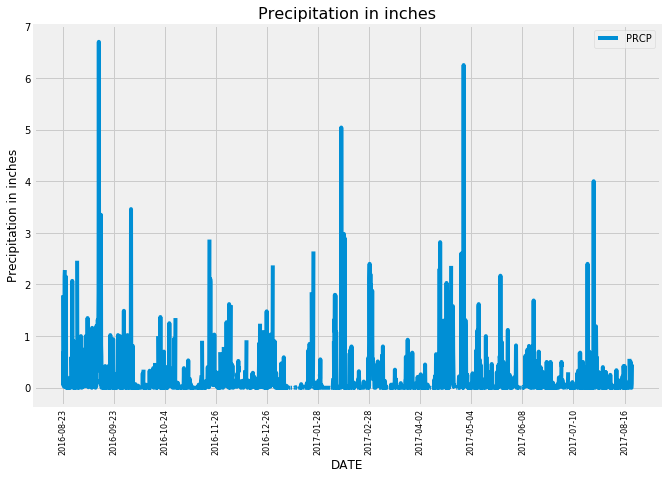

In [146]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#df['date'].max()
#since the last day on record is 8/23/17, I will set today's date to that.

# Calculate the date 1 year ago from today
today_date=dt.date(2017, 8, 23)
year_ago = today_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
year_ago_measurements=session.query(Measurement.prcp, Measurement.date)\
                                .filter(Measurement.date >= year_ago)\
                                .filter(Measurement.date <= today_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
year_ago_msrmnt_df=pd.DataFrame(year_ago_measurements, columns=["prcp","date"])
year_ago_msrmnt_df.set_index('date', inplace=True)


# Sort the dataframe by date
year_ago_msrmnt_df=year_ago_msrmnt_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
figure, ax = plt.subplots(figsize=(10,7))

x=np.arange(len(year_ago_msrmnt_df))
y=year_ago_msrmnt_df.prcp
ax.plot(x, y, label='PRCP')

# Rotate the xticks for the dates
ax.xtick_list=np.arange(0,year_ago_msrmnt_df.shape[0])
ax.set_xticks(xtick_list)
ax.set_xticklabels([year_ago_msrmnt_df.index[i] for i in xtick_list], rotation=90, fontsize=8)
plt.title("Precipitation in inches", fontsize = 16)
plt.xlabel("DATE",fontsize=12)
plt.ylabel('Precipitation in inches')
plt.legend(fontsize=10, loc='upper right')



In [95]:
# Use Pandas to calcualte the summary statistics for the precipitation data
year_ago_msrmnt_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [100]:
# How many stations are available in this dataset?
session.query(func.distinct(Measurement.station)).count()

9

In [117]:
# What are the most active stations?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station,\
                                     func.count(Measurement.tobs))\
                                    .group_by(Measurement.station)\
                                    .order_by(func.count(Measurement.tobs)\
                                    .desc())\
                                    .all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [119]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

#taking the first tiem from the db above and naming it most_active_station_is
most_active_station_id = most_active_stations[0].station
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
              .filter(Measurement.station == most_active_station_id).all()

[(54.0, 85.0, 71.66378066378067)]

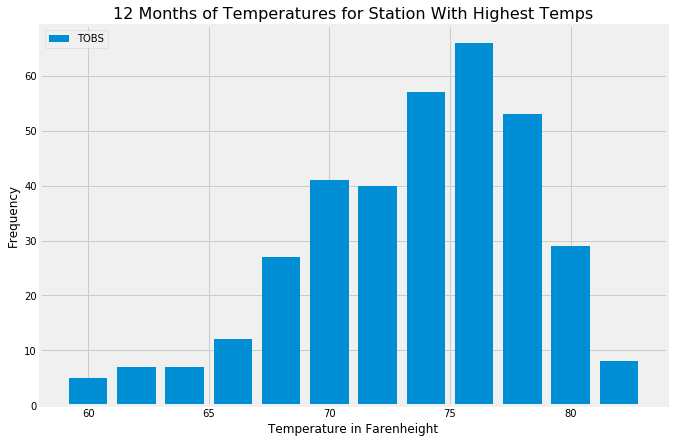

In [164]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html
# https://youtu.be/ZyTO4SwhSeE

figure, ax = plt.subplots(figsize=(10,7))
year_ago_max_temp = session.query(Measurement.tobs)\
                            .filter(Measurement.station == most_active_station_id)\
                            .filter(Measurement.date >= year_ago)\
                            .filter(Measurement.date < today_date).all()
year_ago_max_temp_df = pd.DataFrame(year_ago_max_temp, columns=['tobs'])

bins=[59,61,63,65,67,69,71,73,75,77,79,81,83,]
plt.hist(year_ago_max_temp_df.tobs,bins,histtype='bar', rwidth=0.8, label="TOBS")
plt.title("12 Months of Temperatures for Station With Highest Temps", fontsize = 16)
plt.xlabel("Temperature in Farenheight",fontsize=12)
plt.ylabel('Frequency')
plt.legend(fontsize=10, loc='upper left')


In [182]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [183]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
first_day = today_date - dt.timedelta(days=365)
last_day = first_day + dt.timedelta(days=10)

tmin, tavg, tmax = calc_temps(first_day, last_day)[0]
print(tmin, tavg, tmax)

71.0 78.43055555555556 84.0


(0, 100)

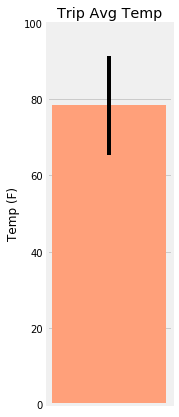

In [160]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

figure, ax = plt.subplots(figsize=(2,7))

plt.subplot()
plt.bar(x=0, height=tavg, yerr=(tmax-tmin), color='lightsalmon')
plt.ylabel('Temp (F)')
plt.title('Trip Avg Temp')
plt.xticks([])
plt.ylim(0,100)




In [180]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = [Station.name, Station.latitude, Station.longitude, Station.elevation]
rainfall_data = session.query(*sel).filter(Measurement.station == Station.station )\
                       .filter(Measurement.date >= year_ago, Measurement.date < today_date)\
                       .order_by(Measurement.prcp.desc()).limit(10).all()

rainfall_data



[('MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 ('WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 ('MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

## Optional Challenge Assignment

In [184]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [187]:
# calculate the daily normals for your trip

# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
start_date = today_date
vacation_length = 10
vacation_dates = [(start_date + dt.timedelta(days=i)).strftime("%m-%d") for i in range(vacation_length)]
normals = [daily_normals(date)[0] for date in vacation_dates]
normals

[(67.0, 76.6923076923077, 87.0),
 (70.0, 75.96153846153847, 84.0),
 (69.0, 76.96078431372548, 82.0),
 (71.0, 76.56862745098039, 84.0),
 (68.0, 76.28301886792453, 84.0),
 (67.0, 76.73469387755102, 86.0),
 (70.0, 76.23529411764706, 85.0),
 (68.0, 76.41666666666667, 84.0),
 (67.0, 76.84, 85.0),
 (69.0, 77.0, 82.0)]

In [188]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
normals_df

,tmin,tavg,tmax
0,67.0,76.692308,87.0
1,70.0,75.961538,84.0
2,69.0,76.960784,82.0
3,71.0,76.568627,84.0
4,68.0,76.283019,84.0
5,67.0,76.734694,86.0
6,70.0,76.235294,85.0
7,68.0,76.416667,84.0
8,67.0,76.840000,85.0
9,69.0,77.000000,82.0


Text(0.5,1,'Daily normals')

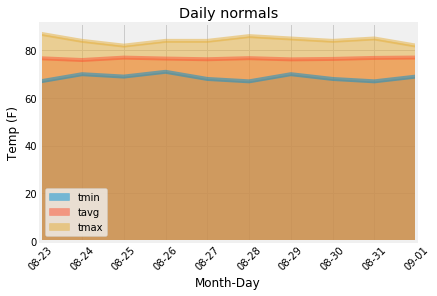

In [192]:
# Plot the daily normals as an area plot with `stacked=False`
ax = normals_df.plot.area(stacked=False)
ax.set_ylabel('Temp (F)')
ax.set_xlabel('Month-Day')
ax.set_xlim(0,9)
ax.set_xticklabels(vacation_dates, rotation=45)
ax.set_title('Daily normals')
